# Retirement Planner

---

## Environment Setup

In [1]:
# Import libraries and dependencies
import numpy as np
import pandas as pd
import os
from datetime import datetime, timedelta
import matplotlib.pyplot as plt
import alpaca_trade_api as tradeapi

%matplotlib inline

In [2]:
# Set the random seed for resutls reproducibility (for testing purposes only)
np.random.seed(42)

---

## Portfolio Planner

In this activity, you will use the Alpaca API to grab historical data for a `60/40` portfolio using `SPY` to represent the stock portion and `AGG` to represent the bonds.

In [3]:
# Load .env enviroment variables
from dotenv import load_dotenv
load_dotenv()

# Set Alpaca API key and secret
alpaca_api_key = os.getenv("ALPACA_API_KEY")
alpaca_secret_key = os.getenv("ALPACA_SECRET_KEY")

# Create the Alpaca API object
api = tradeapi.REST(
    alpaca_api_key,
    alpaca_secret_key,
    api_version="v2")

In [4]:
# Confrim Alpaca API Keys were imported properly
print(len(alpaca_api_key))
print(len(alpaca_secret_key))

20
40


# Data Collection

In this step, you will need to use the Alpaca api to fetch closing prices for the `SPY` and `AGG` tickers. Save the results as a pandas DataFrame

In [5]:
# Subset your tickers, then pull returns data:
# Set the ticker
ticker = ["SPY", "AGG"]

# Set timeframe to '1D'
timeframe = "1D"

# Set start and end datetimes of 1 year, between now and 365 days ago.
start_date = pd.Timestamp('2019-01-01', tz='America/New_York').isoformat()
end_date = pd.Timestamp('2019-12-31', tz='America/New_York').isoformat()

# Get 1 year's worth of historical data for SPY and AGG
df = api.get_barset(
    ticker,
    timeframe,
    limit=None,
    start=start_date,
    end=end_date,
    after=None,
    until=None,
).df

# Drop unnecessary columns
df = df.drop(
    columns=['open', 'high', 'low', 'volume'],
    level=1
)

In [6]:
# Display sample data
df.head()

,AGG,SPY
,close,close
2019-01-02 00:00:00-05:00,106.585,249.89
2019-01-03 00:00:00-05:00,107.020,244.46
2019-01-04 00:00:00-05:00,106.695,252.41
2019-01-07 00:00:00-05:00,106.470,254.40
2019-01-08 00:00:00-05:00,106.420,256.65


In [7]:
# Rename the closing columns to "AGG Close" & "SPY Close"
df.columns = ['AGG_Close', 'SPY_Close']
df.head()

,AGG_Close,SPY_Close
2019-01-02 00:00:00-05:00,106.585,249.89
2019-01-03 00:00:00-05:00,107.020,244.46
2019-01-04 00:00:00-05:00,106.695,252.41
2019-01-07 00:00:00-05:00,106.470,254.40
2019-01-08 00:00:00-05:00,106.420,256.65


---

## Monte Carlo Simulation

In this step, you will run Monte Carlo Simulations for your portfolio to model portfolio performance at different retirement ages. 

Complete the following steps:

1. Calculate the daily returns for the SPY and AGG closing prices.

2. Calculate volatility for both the SPY and AGG closing prices.

3. Find the last day's closing price for both stocks and save those as variables

4. Run a Monte Carlo Simulation of at least `100` iterations and generate at least `30` years of closing prices

**Hint:** There are `252` trading days per year, so the number of records to generate for each Monte Carlo run will be `252 days * 30 years`.

In [8]:
# Calculate the daily roi for the stocks
daily_returns = df.pct_change()

# Display sample data
daily_returns.head()

,AGG_Close,SPY_Close
2019-01-02 00:00:00-05:00,NaN,NaN
2019-01-03 00:00:00-05:00,0.004081,-0.021730
2019-01-04 00:00:00-05:00,-0.003037,0.032521
2019-01-07 00:00:00-05:00,-0.002109,0.007884
2019-01-08 00:00:00-05:00,-0.000470,0.008844


In [9]:
# Calculate the average daily returns for both stocks
spy_avg_daily_returns = daily_returns.mean()["SPY_Close"]
print(f"SPY Average Daily Returns: {spy_avg_daily_returns}")
agg_avg_daily_returns = daily_returns.mean()["AGG_Close"]
print(f"AGG Average Daily Returns: {agg_avg_daily_returns}")

SPY Average Daily Returns: 0.0010401250682146959
AGG Average Daily Returns: 0.00021276976507473064


In [10]:
# Compute daily volatility for SPY and AGG 
spy_std_deviation = daily_returns.std()["SPY_Close"]
print(f"SPY Volatility: {spy_std_deviation}")
agg_std_deviation = daily_returns.std()["AGG_Close"]
print(f"AGG Volatility: {agg_std_deviation}")

SPY Volatility: 0.007820053413439366
AGG Volatility: 0.0020886019741764646


In [11]:
# Print the results
# print(f"SPY volatility is: {SPY_volatility}")
# print(f"AGG volatility is: {AGG_volatility}")
# 0.007820053413439366
# 0.002089826211646555

In [12]:
# Save the last day's closing price as a variable 
SPY_last_day_closing_price = df['SPY_Close'][-1]
print(f"SPY Last Day Closing Price: ${SPY_last_day_closing_price}")
AGG_last_day_closing_price = df['AGG_Close'][-1]
print(f"AGG Last Day Closing Price: ${AGG_last_day_closing_price}")

SPY Last Day Closing Price: $321.92
AGG Last Day Closing Price: $112.37


In [13]:
# Print the last day's closing price for both stocks
# print(f"The last day's closing price for SPY is: ${SPY_last_day_closing_price}")
# print(f"The last day's closing price for AGG is: ${AGG_last_day_closing_price}")

In [14]:
# Setup the Monte Carlo Parameters
number_simulations = 500
number_records = 252 * 30
monte_carlo = pd.DataFrame()
portfolio_cumulative_returns = pd.DataFrame()

In [15]:
# Run the Monte Carlo Simulation

# Run the simulation of projecting stock prices for the number of simulations; 500 iterations
for n in range(number_simulations):
    
    # Initialize the simulated prices list with the last closing price of `SPY` and `AGG`
    spy_simulated_prices = [SPY_last_day_closing_price]
    agg_simulated_prices = [AGG_last_day_closing_price]
    
    # Simulate the returns for the desired period; 252 * 30
    for i in range(number_records):
        
        # Calculate the simulated price using the last price within the list
        simulated_spy_price = spy_simulated_prices[-1] * (1 + np.random.normal(spy_avg_daily_returns,spy_std_deviation))
        simulated_agg_price = agg_simulated_prices[-1] * (1 + np.random.normal(agg_avg_daily_returns,agg_std_deviation))
    
        # Append the simulated price to the list
        spy_simulated_prices.append(simulated_spy_price)
        agg_simulated_prices.append(simulated_agg_price)
    
    # Append a simulated prices of each simulation to DataFrame
    monte_carlo["SPY prices"] = pd.Series(spy_simulated_prices)
    monte_carlo["AGG prices"] = pd.Series(agg_simulated_prices)
    
    # Calculate the daily returns of simulated prices
    simulated_daily_returns = monte_carlo.pct_change()
    
    # Set the portfolio weights (60% SPY & 40% AGG)
    weights = [0.4, 0.6]
    
    # Use the `dot` function with the weights to multiply weights with each column"s simulated daily returns
    portfolio_daily_returns = simulated_daily_returns.dot(weights)
    
     # Calculate the normalized, cumulative return series
    portfolio_cumulative_returns[n] = (1 + portfolio_daily_returns.fillna(0)).cumprod()


In [16]:
# Check that the simulation ran successfully
# Print records from the DataFrame
portfolio_cumulative_returns.head() 

,0,1,2,3,4,5,6,7,8,9,...,490,491,492,493,494,495,496,497,498,499
0,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
1,1.001924,0.997505,0.995700,1.000705,1.005416,1.003571,1.005572,0.999815,1.001367,0.998857,...,1.001749,0.996288,1.004930,1.000495,0.998097,1.002516,0.997957,0.997280,1.001753,0.997615
2,1.006411,1.000684,0.996078,0.998851,1.007231,0.997945,1.001722,0.992297,1.000858,1.003898,...,1.003733,1.001281,1.007210,1.002168,0.999241,0.998881,0.997915,0.997455,1.001487,1.000715
3,1.005926,1.000743,0.998432,0.995538,1.006644,0.998970,1.004883,0.987721,1.000825,1.010425,...,1.004013,1.002157,1.010372,1.003880,0.994553,0.998616,1.001211,1.000151,1.004101,1.000766
4,1.012409,1.003035,0.997002,0.999986,1.008601,0.996445,1.004989,0.985181,1.006183,1.004915,...,1.004917,1.001715,1.009675,1.006305,0.998787,0.996727,0.997377,1.001179,1.006803,1.003199


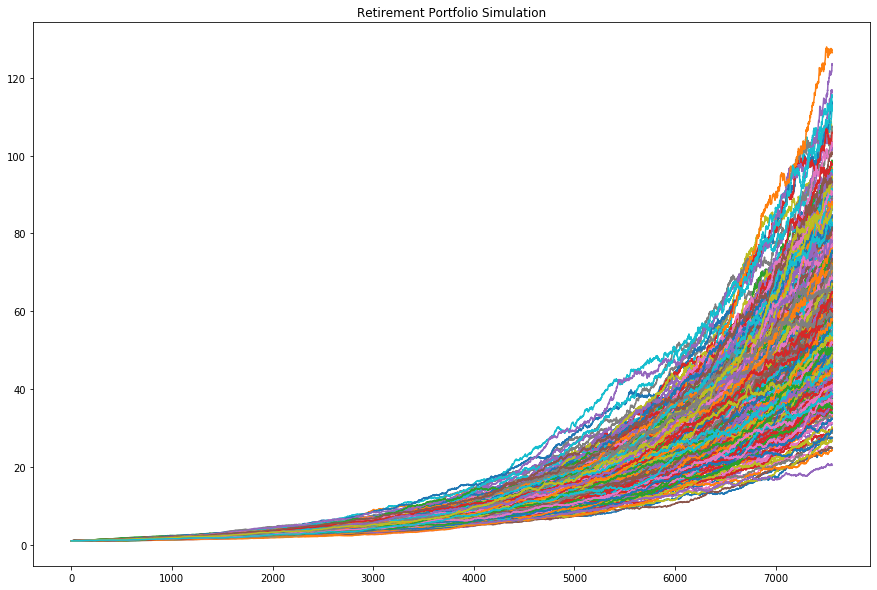

In [17]:
# Visualize the Simulation
plot_title = "Retirement Portfolio Simulation"
portfolio_cumulative_returns.plot(legend=None, title=plot_title, figsize=(15,10))

In [18]:
# Select the last row for the cumulative returns (cumulative returns at 30 years)
portfolio_cumulative_returns_30_years = portfolio_cumulative_returns.iloc[-1, :]
portfolio_cumulative_returns_30_years.head()

0    63.797071
1    55.436929
2    68.111555
3    67.712711
4    66.032144
Name: 7560, dtype: float64

In [19]:
# Display the 90% confidence interval for the ending returns
confidence_interval = portfolio_cumulative_returns_30_years.quantile(q=[.05, .95])
confidence_interval

0.05    34.496951
0.95    92.235803
Name: 7560, dtype: float64

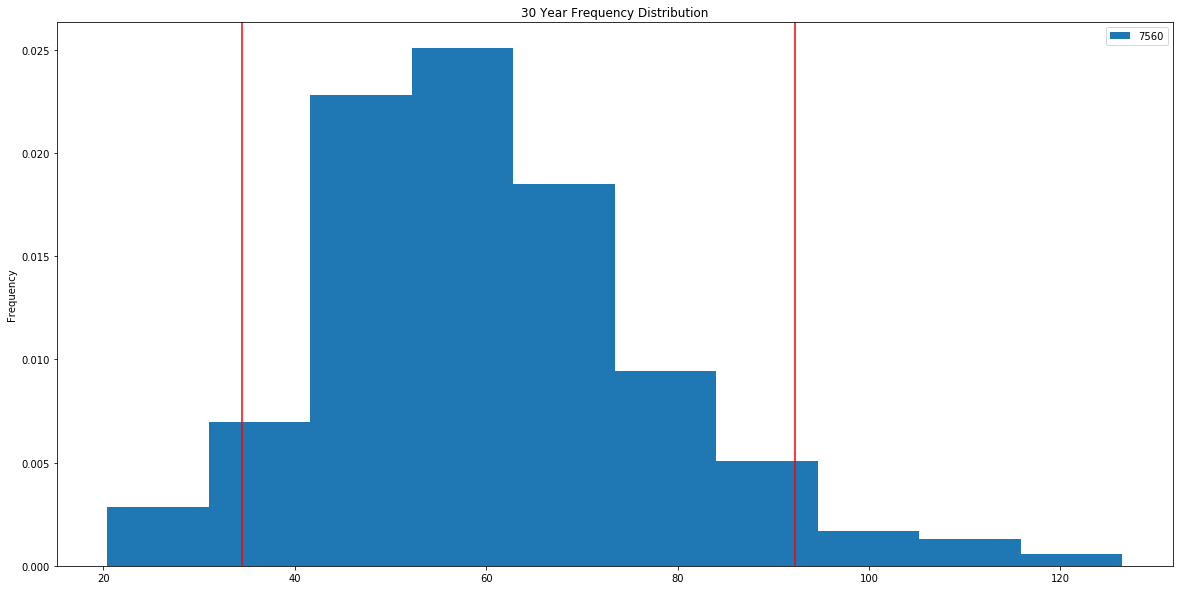

In [49]:
# Visualize the distribution of the ending returns
plt.figure();
portfolio_cumulative_returns_30_years.plot(kind="hist", density=True, bins=10, title="30 Year Frequency Distribution", figsize=(20,10), legend=True)
plt.axvline(confidence_interval.iloc[0], color="r")
plt.axvline(confidence_interval.iloc[1], color="r")

---

## Retirement Analysis

In this section, you will use the monte carlo model to answer the following retirement planning questions:

1. What are the expected cumulative returns at `30` years for the `10th`, `50th`, and `90th` percentiles?

2. Given an initial investment of `$20,000`, what is the expected return in dollars at the `10th`, `50th`, and `90th` percentiles?

3. Given the current projected annual income from the Plaid analysis, will a `4%` withdrawal rate meet or exceed that value at the `10th` percentile? Note: This is basically determining if retirement income is equivalent to current income.

4. How would a `50%` increase in the initial investment amount affect the `4%` retirement withdrawal? In other words, what happens if the initial investment had been bigger?

### What are the expected cumulative returns at 30 years for the 10th, 50th, and 90th percentiles?

In [21]:
# Compute cumulative returns
expected_30yr_cumulative_returns = portfolio_cumulative_returns_30_years.quantile(q=[0.1,0.5,0.9])

# Print the cumulative returns results
print(f"The expected cumulative returns at 30 years for the 10th, 50th, and 90th percentile are:")
expected_30yr_cumulative_returns

The expected cumulative returns at 30 years for the 10th, 50th, and 90th percentile are:


0.1    41.261628
0.5    57.737947
0.9    82.328217
Name: 7560, dtype: float64

### Given an initial investment of `$20,000`, what is the expected portfolio return in dollars at the 10th, 50th, and 90th percentiles?

In [22]:
# Set the Initial investment 
initial_investment = 20000

# Compute expected portfolio return
expected_portfolio_return_10th_percentile = round(initial_investment + (initial_investment * expected_30yr_cumulative_returns.iloc[0]))
expected_portfolio_return_50th_percentile = round(initial_investment + (initial_investment * expected_30yr_cumulative_returns.iloc[1]))
expected_portfolio_return_90th_percentile = round(initial_investment + (initial_investment * expected_30yr_cumulative_returns.iloc[2]))

# Print the results
print(f"Given an initial investment of $20 000, the expected portfolio returns are:")
print(f"Tenth percentile expected returns: ${expected_portfolio_return_10th_percentile}")
print(f"Fiftieth percentile expected returns: ${expected_portfolio_return_50th_percentile}")
print(f"Nintieth percentile expected returns: ${expected_portfolio_return_90th_percentile}")


Given an initial investment of $20 000, the expected portfolio returns are:
Tenth percentile expected returns: $845233.0
Fiftieth percentile expected returns: $1174759.0
Nintieth percentile expected returns: $1666564.0


### Given the current projected annual income from the Plaid analysis, will a 4% withdraw rate from the retirement portfolio meet or exceed that value at the 10th percentile?

Note: This is effectively saying that 90% of the expected returns will be greater than the return at the 10th percentile, so this can help measure the uncertainty about having enough funds at retirement

In [23]:
# Set Plaid's projected income
# The projected income I chose to use from the Plaid Income analysis is a post tax figure
projected_annual_income = 6085

# Calculate the 4% withdrawal for the ending return as retirement income
ending_return_withdrawl = (expected_portfolio_return_10th_percentile) * .04
ending_return_withdrawl = round(ending_return_withdrawl)

# Determine if the retirement income meets or exceeds the current projected income
if (ending_return_withdrawl) > projected_annual_income:
    print(f"The 4% withdrawl from the tenth percentile, ${ending_return_withdrawl} will exceed the post tax projected annual income of ${projected_annual_income} from the Plaid Income Analysis")
else:
    print(f"The 4% withdrawl from the tenth percentile, ${ending_return_withdrawl} is either at par or below the post tax projected annual income of ${projected_annual_income} from the Plaid Income Analysis")


The 4% withdrawl from the tenth percentile, $33809.0 will exceed the post tax projected annual income of $6085 from the Plaid Income Analysis


### How would a 50% increase in the initial investment amount affect the 4% retirement withdrawal?

**NOTE:**

My understanding of this question is the following: the initial investment is `$20 000`, therefore, a 50% increase in this principle amount would indicate a new investment of `$30 000.`



In [24]:
# Part 1 of Calculations:
# Re-calculate the retirement income with a 50% increase in the initial investment amount

# Set the new ivestment (initial investment multipled by a 50% increase)
increased_investment = 20000 * 1.5

# Compute expected portfolio return for the new investment (increased_investment variable)
new_expected_portfolio_return_10th_percentile = round(increased_investment + (increased_investment * expected_30yr_cumulative_returns.iloc[0]))
new_expected_portfolio_return_50th_percentile = round(increased_investment + (increased_investment * expected_30yr_cumulative_returns.iloc[1]))
new_expected_portfolio_return_90th_percentile = round(increased_investment + (increased_investment * expected_30yr_cumulative_returns.iloc[2]))

# Print the results
print(f"Given the 50% increase in the initial investment ($20 000), the expected portfolio returns for a $30 000 investment are:")
print(f"Tenth percentile expected returns: ${new_expected_portfolio_return_10th_percentile}")
print(f"Fiftieth percentile expected returns: ${new_expected_portfolio_return_50th_percentile}")
print(f"Nintieth percentile expected returns: ${new_expected_portfolio_return_90th_percentile}")


Given the 50% increase in the initial investment ($20 000), the expected portfolio returns for a $30 000 investment are:
Tenth percentile expected returns: $1267849.0
Fiftieth percentile expected returns: $1762138.0
Nintieth percentile expected returns: $2499847.0


In [25]:
# Part 2 of Calculations:

# Re-calculate the retirement income with a 50% increase in the initial investment amount
# Set Plaid's projected income
# The projected income I chose to use from the Plaid Income analysis is a post tax figure
projected_annual_income = 6085

# Calculate the 4% withdrawal for the ending return as retirement income
new_ending_return_withdrawl = (new_expected_portfolio_return_10th_percentile) * .04
new_ending_return_withdrawl = round(new_ending_return_withdrawl)


# Determine if the retirement income meets or exceeds the current projected income
if (new_ending_return_withdrawl) > projected_annual_income:
    print(f"The 4% withdrawl from the tenth percentile, ${new_ending_return_withdrawl}, will exceed the post tax projected annual income of ${projected_annual_income}, from the Plaid Income Analysis. Therefore, the increase in initial investment results in a higher retirement income per annum.")
elif (new_ending_withdrawl) == projected_annual_income:
    print(f"The 4% withdrawl from the tenth percentile, ${new_ending_return_withdrawl}, meets the post tax projected annual income of ${projected_annual_income}, from the Plaid Income Analysis. Therefore, the increase in initial investment results in a lower retirement income per annum")
else:
    print(f"The 4% withdrawl from the tenth percentile, ${new_ending_return_withdrawl}, is below the post tax projected annual income of ${projected_annual_income}, from the Plaid Income Analysis. Therefore, the increase in initial investment results in a lower retirement income per annum")


The 4% withdrawl from the tenth percentile, $50714.0, will exceed the post tax projected annual income of $6085, from the Plaid Income Analysis. Therefore, the increase in initial investment results in a higher retirement income per annum.


### Retirement Analysis Optional Challenge

Use the Monte Carlo data and calculate the cumulative returns at the `5%`, `50%`, and `95%` quartiles and plot this data as a line chart to see how the cumulative returns change over the life of the investment.

In this section, you need to calculate and plot the cumulative returns for the median and `90%` confidence intervals. This plot shows the expected cumulative returns for any given day between the first day and the last day of investment. 

In [26]:
# Compute projected returns 

# Initiate quartile variables and DataFrame
cumulative_returns_5_percent = []
cumulative_returns_median = []
cumulative_returns_95_percent = []
projected_returns = pd.DataFrame ()

# Calculate the projected returns
for x in range(number_records):
    cumulative_returns_5_percent.append(portfolio_cumulative_returns.iloc[x,:].quantile(0.05))
    cumulative_returns_median.append(portfolio_cumulative_returns.iloc[x,:].quantile(0.50))
    cumulative_returns_95_percent.append(portfolio_cumulative_returns.iloc[x,:].quantile(0.95))

projected_returns["5% Quartile"]=pd.Series(cumulative_returns_5_percent)
projected_returns["Median"]=pd.Series(cumulative_returns_median)
projected_returns["95% Quartile"]=pd.Series(cumulative_returns_95_percent)

# Display the projected returns sample data
projected_returns.head()


,5% Quartile,Median,95% Quartile
0,1.000000,1.000000,1.000000
1,0.995077,1.000716,1.006362
2,0.993301,1.001408,1.008720
3,0.992764,1.001858,1.011205
4,0.991196,1.002661,1.012922


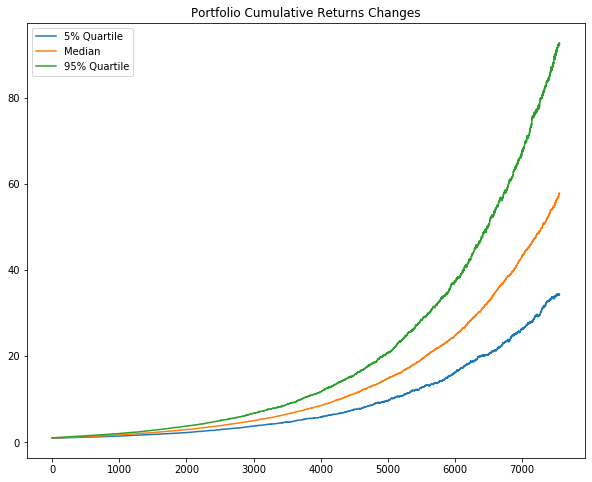

In [27]:
# Plot the cumulative returns over time
projected_returns.plot(legend=True, figsize=(10,8), title="Portfolio Cumulative Returns Changes")

### Early Retirement Optional Challenge

Harold is impressed with your work on this planner, but thinks that 30 years seems like a very long time to wait to retire! Harold wants to know if the retirement plan could be adjusted to retire earlier than normal. Try adjusting the portfolio to either include more risk (a higher stock than bond ratio), or to have a larger initial investment and then rerun the retirement analysis to see what it would take to retire in 5 years, instead of 30!

In [37]:
# Setup the Monte Carlo Parameters for this challenge
number_simulations = 500
number_records = 252 * 5
monte_carlo = pd.DataFrame()
portfolio_cumulative_returns = pd.DataFrame()

In [40]:
# Run the Monte Carlo Simulation
# Run the Monte Carlo Simulation

# Run the simulation of projecting stock prices for the number of simulations; 500 iterations
for n in range(number_simulations):
    
    # Initialize the simulated prices list with the last closing price of `SPY` and `AGG`
    spy_simulated_prices = [SPY_last_day_closing_price]
    agg_simulated_prices = [AGG_last_day_closing_price]
    
    # Simulate the returns for the desired period; 252 * 30
    for i in range(number_records):
        
        # Calculate the simulated price using the last price within the list
        simulated_spy_price = spy_simulated_prices[-1] * (1 + np.random.normal(spy_avg_daily_returns,spy_std_deviation))
        simulated_agg_price = agg_simulated_prices[-1] * (1 + np.random.normal(agg_avg_daily_returns,agg_std_deviation))
    
        # Append the simulated price to the list
        spy_simulated_prices.append(simulated_spy_price)
        agg_simulated_prices.append(simulated_agg_price)
    
    # Append a simulated prices of each simulation to DataFrame
    monte_carlo["SPY prices"] = pd.Series(spy_simulated_prices)
    monte_carlo["AGG prices"] = pd.Series(agg_simulated_prices)
    
    # Calculate the daily returns of simulated prices
    simulated_daily_returns = monte_carlo.pct_change()
    
    # Set the portfolio weights (60% SPY & 40% AGG)
    weights = [0.4, 0.6]
    
    # Use the `dot` function with the weights to multiply weights with each column"s simulated daily returns
    portfolio_daily_returns = simulated_daily_returns.dot(weights)
    
     # Calculate the normalized, cumulative return series
    portfolio_cumulative_returns[n] = (1 + portfolio_daily_returns.fillna(0)).cumprod()


In [41]:
# Check that the simulation ran successfully
# Print records from the DataFrame
portfolio_cumulative_returns.head()

,0,1,2,3,4,5,6,7,8,9,...,490,491,492,493,494,495,496,497,498,499
0,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
1,0.998932,0.997903,0.997232,1.002554,1.003962,1.003449,1.002800,0.997225,1.000448,0.999886,...,0.997878,1.002169,0.997797,1.004971,0.999834,0.999635,0.997985,1.003153,1.003239,1.005340
2,1.001796,0.999154,1.006238,1.001544,1.003928,1.003646,1.001761,0.997910,1.001128,1.000488,...,1.001436,1.002110,0.999989,1.005946,1.001898,1.008385,0.997987,1.006410,1.001626,1.004444
3,1.005397,0.996697,1.012977,1.001653,1.004966,1.004288,1.006478,0.989409,0.998094,0.994938,...,1.006424,1.004503,1.006328,1.003071,1.008113,1.006860,0.999327,1.002268,1.000627,1.010432
4,1.007657,0.991524,1.013102,1.004566,1.006047,1.005162,1.008371,0.988157,0.999415,0.996284,...,1.009179,1.001592,1.007641,1.000737,1.009317,1.011466,1.003765,1.001174,1.000728,1.007533


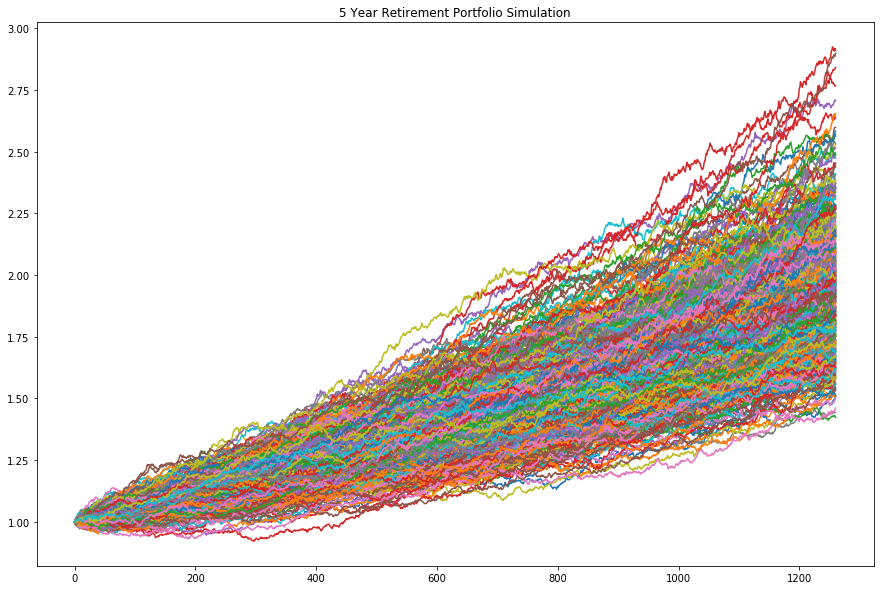

In [42]:
# Visualize the Simulation
plot_title = "5 Year Retirement Portfolio Simulation"
portfolio_cumulative_returns.plot(legend=None, title=plot_title, figsize=(15,10))

In [43]:
# Select the last row for the cumulative returns (cumulative returns at 5 years)
portfolio_cumulative_returns_5_years = portfolio_cumulative_returns.iloc[-1, :]
portfolio_cumulative_returns_5_years.head()

0    1.796194
1    1.835885
2    2.275095
3    2.245675
4    1.656759
Name: 1260, dtype: float64

In [44]:
# Display the 90% confidence interval for the ending returns
confidence_interval = portfolio_cumulative_returns_5_years.quantile(q=[.05, .95])
confidence_interval

0.05    1.606624
0.95    2.369866
Name: 1260, dtype: float64

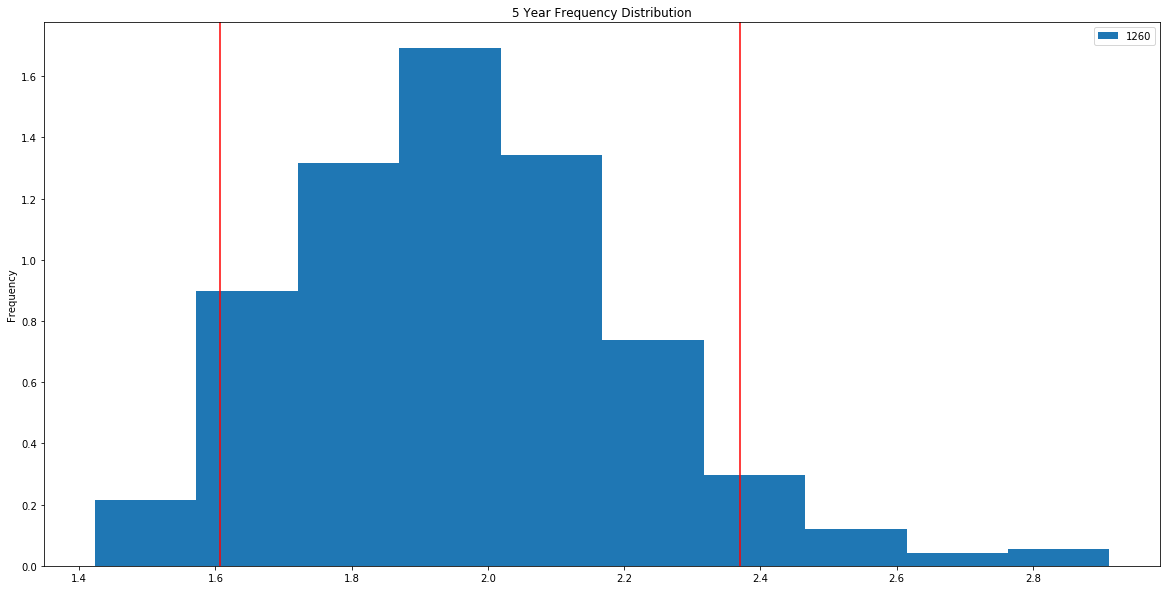

In [45]:
# Visualize the distribution of the ending returns
plt.figure();
portfolio_cumulative_returns_5_years.plot(kind="hist", density=True, bins=10, title="5 Year Frequency Distribution", figsize=(20,10), legend=True)
plt.axvline(confidence_interval.iloc[0], color="r")
plt.axvline(confidence_interval.iloc[1], color="r")